In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Load files
prices_day_m1 = pd.read_csv('prices_round_2_day_-1.csv', sep=';')
prices_day_0 = pd.read_csv('prices_round_2_day_0.csv', sep=';')
prices_day_1 = pd.read_csv('prices_round_2_day_1.csv', sep=';')

# Concatenate
prices = pd.concat([prices_day_m1, prices_day_0, prices_day_1], ignore_index=True)

prices.head()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,-1,0,CROISSANTS,4304,112,NaN,NaN,NaN,NaN,4305,112,NaN,NaN,NaN,NaN,4304.5,0.0
1,-1,0,JAMS,6670,66,6669.0,137.0,NaN,NaN,6671,66,6672.0,137.0,NaN,NaN,6670.5,0.0
2,-1,0,SQUID_INK,2005,1,2002.0,31.0,NaN,NaN,2006,31,NaN,NaN,NaN,NaN,2005.5,0.0
3,-1,0,PICNIC_BASKET1,59284,20,59283.0,18.0,NaN,NaN,59294,2,59295.0,36.0,NaN,NaN,59289.0,0.0
4,-1,0,PICNIC_BASKET2,30606,20,30605.0,18.0,NaN,NaN,30612,20,30613.0,18.0,NaN,NaN,30609.0,0.0


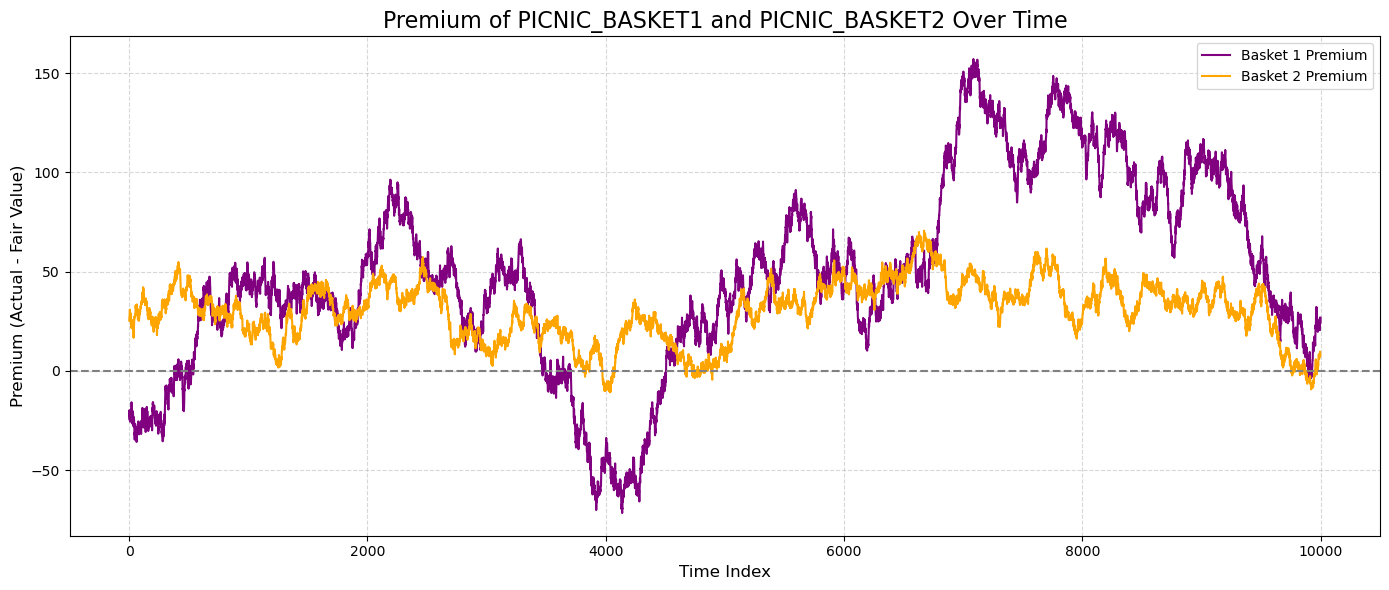

In [9]:
# Baskets
basket_components = ["CROISSANTS", "JAMS", "DJEMBES", "PICNIC_BASKET1", "PICNIC_BASKET2"]

# Aggregate by timestamp and product
mid_price_avg = (
    prices[prices["product"].isin(basket_components)]
    .groupby(["timestamp", "product"])["mid_price"]
    .mean()
    .reset_index()
)

price_pivot = mid_price_avg.pivot(index="timestamp", columns="product", values="mid_price").reset_index()

# Compute fair values
price_pivot["FV_BASKET1"] = (
    6 * price_pivot["CROISSANTS"] +
    3 * price_pivot["JAMS"] +
    1 * price_pivot["DJEMBES"]
)
price_pivot["FV_BASKET2"] = (
    4 * price_pivot["CROISSANTS"] +
    2 * price_pivot["JAMS"]
)

# Calculate premiums
price_pivot["PREMIUM_BASKET1"] = price_pivot["PICNIC_BASKET1"] - price_pivot["FV_BASKET1"]
price_pivot["PREMIUM_BASKET2"] = price_pivot["PICNIC_BASKET2"] - price_pivot["FV_BASKET2"]

price_pivot["tick_number"] = range(len(price_pivot))

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(price_pivot["tick_number"], price_pivot["PREMIUM_BASKET1"], label="Basket 1 Premium", color="purple")
plt.plot(price_pivot["tick_number"], price_pivot["PREMIUM_BASKET2"], label="Basket 2 Premium", color="orange")
plt.axhline(0, color="gray", linestyle="--")

plt.title("Premium of PICNIC_BASKET1 and PICNIC_BASKET2 Over Time", fontsize=16)
plt.xlabel("Time Index", fontsize=12)
plt.ylabel("Premium (Actual - Fair Value)", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


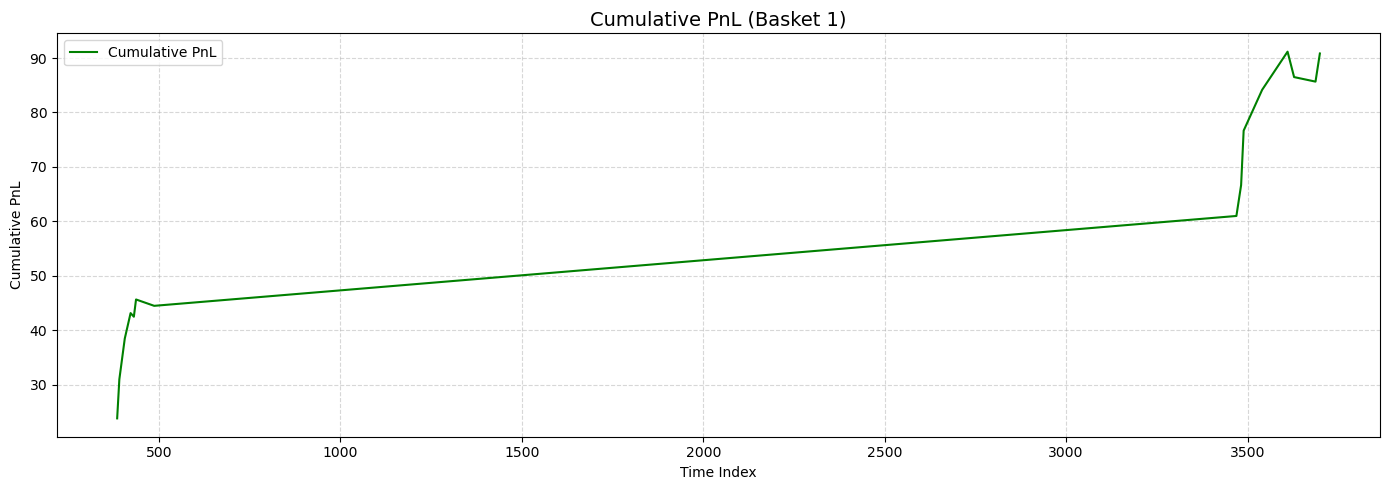

In [39]:
# Basket 1
threshold = 2.9
exit_threshold = 0.3
position = 0 
entry_price = 0
pnl = []
cumulative_pnl = 0
pnl_over_time = []
trades = []

for i, row in price_pivot.iterrows():
    premium = row["PREMIUM_BASKET1"]
    basket_price = row["PICNIC_BASKET1"]
    tick = row["tick_number"]

    if position == 0:
        if premium < -threshold:
            position = 1
            entry_price = basket_price
            trades.append((tick, "LONG", basket_price))
        elif premium > threshold:
            position = -1
            entry_price = basket_price
            trades.append((tick, "SHORT", basket_price))

    elif position == 1:  # currently long
        if abs(premium) < exit_threshold:
            profit = basket_price - entry_price
            cumulative_pnl += profit
            pnl.append(profit)
            pnl_over_time.append((tick, cumulative_pnl))
            trades.append((tick, "EXIT_LONG", basket_price, profit))
            position = 0

    elif position == -1:  # currently short
        if abs(premium) < exit_threshold:
            profit = entry_price - basket_price
            cumulative_pnl += profit
            pnl.append(profit)
            pnl_over_time.append((tick, cumulative_pnl))
            trades.append((tick, "EXIT_SHORT", basket_price, profit))
            position = 0

pnl_df = pd.DataFrame(pnl_over_time, columns=["tick", "cumulative_pnl"])

# Plotting
plt.figure(figsize=(14, 5))
plt.plot(pnl_df["tick"], pnl_df["cumulative_pnl"], label="Cumulative PnL", color="green")
plt.title("Cumulative PnL (Basket 1)", fontsize=14)
plt.xlabel("Time Index")
plt.ylabel("Cumulative PnL")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

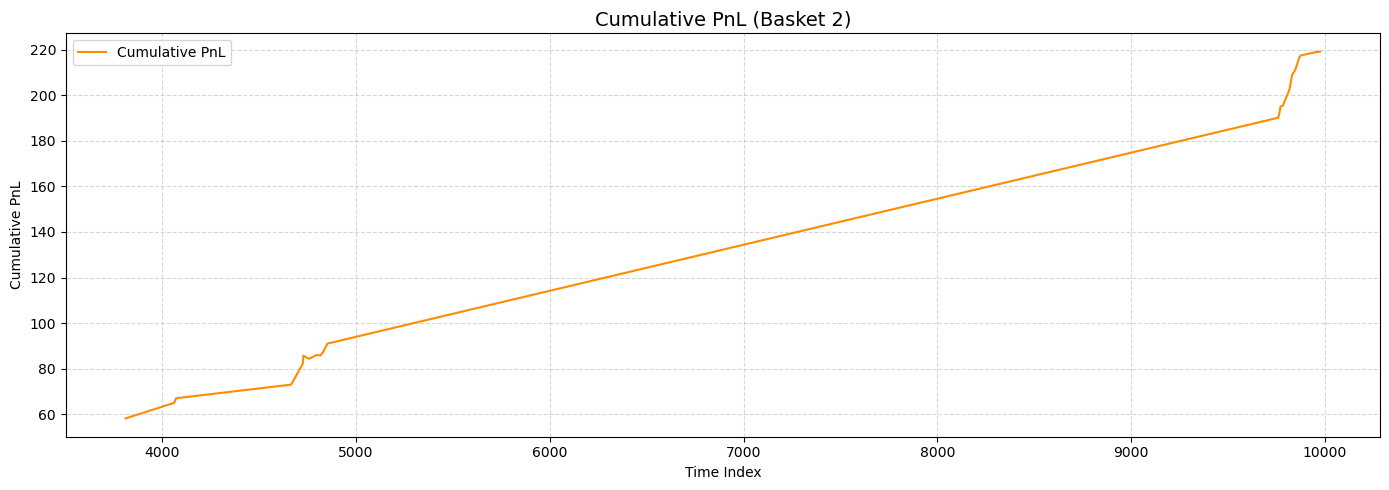

In [ ]:
# Basket 2
threshold = 1.7
exit_threshold = 0.25
position = 0
entry_price = 0
pnl = []
cumulative_pnl = 0
pnl_over_time = []
trades = []

for i, row in price_pivot.iterrows():
    premium = row["PREMIUM_BASKET2"]
    basket_price = row["PICNIC_BASKET2"]
    tick = row["tick_number"]

    if position == 0:
        if premium < -threshold:
            position = 1
            entry_price = basket_price
            trades.append((tick, "LONG", basket_price))
        elif premium > threshold:
            position = -1
            entry_price = basket_price
            trades.append((tick, "SHORT", basket_price))

    elif position == 1 and abs(premium) < exit_threshold:
        profit = basket_price - entry_price
        cumulative_pnl += profit
        pnl.append(profit)
        pnl_over_time.append((tick, cumulative_pnl))
        trades.append((tick, "EXIT_LONG", basket_price, profit))
        position = 0

    elif position == -1 and abs(premium) < exit_threshold:
        profit = entry_price - basket_price
        cumulative_pnl += profit
        pnl.append(profit)
        pnl_over_time.append((tick, cumulative_pnl))
        trades.append((tick, "EXIT_SHORT", basket_price, profit))
        position = 0

# Plotting
pnl_df2 = pd.DataFrame(pnl_over_time, columns=["tick", "cumulative_pnl"])

plt.figure(figsize=(14, 5))
plt.plot(pnl_df2["tick"], pnl_df2["cumulative_pnl"], label="Cumulative PnL", color="darkorange")
plt.title("Cumulative PnL (Basket 2)", fontsize=14)
plt.xlabel("Time Index")
plt.ylabel("Cumulative PnL")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()